   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.0 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging to Training/Logs/DQN_1
Base: 429.20, Menu: 28.50
Discount reduction prevented: action 25 maintained
Base: 411.90, Menu: 24.77
Base: 338.21, Menu: 10000.00
Discount reduction prevented: action 21 maintained
Base: 330.20, Menu: 10000.00
Base: 46.98, Menu: 10000.00
Base: 387.93, Menu: 28.50
Base: 398.84, Menu: 26.18
Base: 385.28, Menu: 10000.00
Discount reduction prevented: action 5 maintained
Base: 374.51, Menu: 10000.00
Base: 361.44, Menu: 10000.00
Discount reduction prevented: action 17 maintained
Base: 193.18, Menu: 10000.00
Base: 422.71, Menu: 28.50
Base: 283.78, Menu: 25.58
Discount reduction prevented: action 19 maintained
Base: 276.85, Menu: 10000.00
Discount reduction prevented: action 12 maintained
Base: 270.96, Menu: 10000.00
Base: 9.00, Menu: 10000.00
Base: 331.11, Menu: 28.50
Base: 180.44, Menu: 23.40
Discount reduction prevented: action 73 maintained
Base: 176.53, Menu: 10000.00
Base: 38.34, Menu: 10000.00
-----------------------------------
| rollout/            |  

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    time_elapsed     | 679      |
|    total_timesteps  | 197433   |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 21.5     |
|    n_updates        | 49333    |
----------------------------------
Base: 418.63, Menu: 28.50
Base: 132.72, Menu: 25.68
Base: 129.96, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.80, Menu: 28.50
Base: 132.73, Menu: 25.68
Base: 129.95, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.66, Menu: 28.50
Base: 35.58, Menu: 25.68
Base: 34.89, Menu: 0.00
Base: 14.31, Menu: 0.00
Base: 418.73, Menu: 28.50
Base: 35.58, Menu: 25.68
Base: 34.89, Menu: 0.00
Base: 14.31, Menu: 0.00
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 18.7     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 51280    |
|    fps              | 290      |
|    time_elapsed     | 

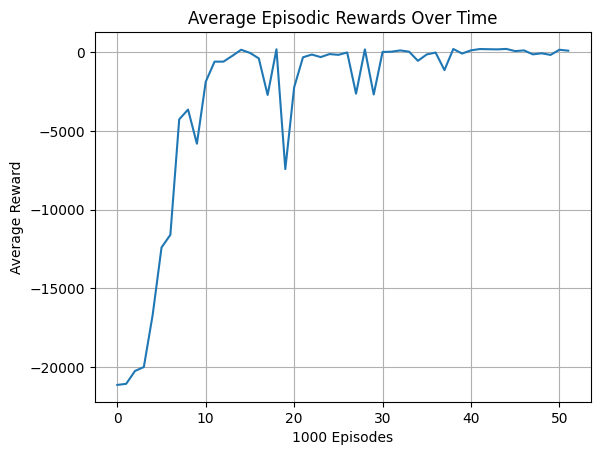

In [3]:
!pip install -q stable-baselines3[extra]
!pip install -q 'shimmy>=2.0'
!pip install -q gymnasium

import os  # Provides functions for interacting with the operating system (e.g., file paths)
import numpy as np  # Numerical computations and array handling
import matplotlib.pyplot as plt  # Plotting library for visualization
from scipy.integrate import trapezoid  # Numerical integration using trapezoidal rule

import gymnasium as gym  # Reinforcement learning environment framework
from gymnasium.spaces import Discrete, MultiDiscrete  # Space definitions for actions and observations

from stable_baselines3 import DQN  # Deep Q-Network implementation from stable-baselines3
from stable_baselines3.common.callbacks import BaseCallback  # Custom callback functionality

# ----------------------
# Parameters definition
# ----------------------
beta = 1.83              # Coefficient that controls influence of latent demand on total demand
landa = 0.0067           # Decay rate for latent demand over time
alpha_new = 1.83         # Coefficient that captures sensitivity of demand to price
p = 4.5                  # Base price of the product without any discount
D0 = 9.79                # Baseline demand level when other factors are neutral
C0 = 1                   # (Reserved) Placeholder parameter, not currently used
Q0 = 740                 # Initial inventory at the start of simulation
T = 10                   # Total time horizon (in days)
C_f = 10                 # Fixed menu cost when changing prices
C_u = 0.025              # Variable menu cost per unit of remaining inventory when price changes
C_w = 4.0                # Waste cost for unsold inventory at the end
MAX_PRICE_CHANGES = 2.0  # Maximum allowed number of price changes

# ----------------------
# Custom Promotion Environment
# ----------------------
class PromotionEnv(gym.Env):  # Define a custom environment by inheriting gym.Env
    def __init__(self):
        super(PromotionEnv, self).__init__()
        # Define action space: agent selects a discount percentage between 0 and 99
        self.action_space = Discrete(100)

        # Define observation space:
        #  [remaining inventory, remaining days, current discount level]
        self.observation_space = MultiDiscrete([Q0 + 1, T + 1, 100])

        # Track how many times the agent has changed price
        self.price_change_count = 0

        # Initialize state variables by calling reset()
        self.reset()

    # ----------------------
    # Convert discount percentage into actual price
    # ----------------------
    def calculate_price(self, discount):
        # Price = base price * (100 - discount) / 100
        return p * (100 - discount) / 100

    # ----------------------
    # Demand function based on price, time, and stochastic components
    # ----------------------
    def calculate_demand(self, price, period):
        # Define time interval in hours (each period = 24 hours)
        start_time = (T - period) * 24
        end_time = start_time + 24

        # Generate 1000 time points in the current day for integration
        t_values = np.linspace(start_time, end_time, num=1000)

        # Random noise parameters
        Lambda = 1.0
        sigma_q = 0.01
        sigma_d = 0.01

        # Gaussian noise for demand and latent demand process
        epsilon_d = np.random.normal(0.0, sigma_d, size=t_values.shape)
        epsilon_q = np.random.normal(0.0, sigma_q, size=t_values.shape)

        # Latent demand decreases exponentially with time + noise
        q_tilde = Lambda * np.exp(-landa * t_values) + epsilon_q

        # Final demand function (linear in price, influenced by q_tilde)
        demand_values = D0 - alpha_new * price + beta * q_tilde + epsilon_d

        # Integrate demand curve to obtain daily demand
        return trapezoid(demand_values, t_values)

    # ----------------------
    # Reward calculation = revenue - menu costs - penalties
    # ----------------------
    def calculate_reward(self, demand, price, action, current_discount):
        # Sales are limited by available inventory
        actual_sales = min(self.state[0], demand)

        # Base reward = revenue from actual sales
        base_reward = max(0, actual_sales) * price

        # Initialize menu cost to zero
        menu_cost = 0

        # If discount changes from previous value
        effective_discount = action
        if effective_discount != self.state[2]:
            if self.price_change_count < MAX_PRICE_CHANGES:
                # Apply fixed + variable menu costs
                menu_cost = C_f + C_u * self.state[0]
                self.price_change_count += 1
            else:
                # Apply a very high penalty if exceeding max price changes
                menu_cost = 10000

        # Final reward = revenue - menu costs
        reward = base_reward - menu_cost

        # Debug print for monitoring reward components
        print(f"Base: {base_reward:.2f}, Menu: {menu_cost:.2f}")
        return reward

    # ----------------------
    # Environment transition logic (state update)
    # ----------------------
    def step(self, action):
        current_discount = self.state[2]  # Current discount in state

        # Rule: discount cannot decrease (prevents rollback)
        if action < current_discount:
            effective_discount = current_discount
            print(f"Discount reduction prevented: action {action} maintained")
        else:
            effective_discount = action

        # Calculate new price and demand for this step
        price = self.calculate_price(effective_discount)
        demand = self.calculate_demand(price, self.period_length)

        # Calculate reward based on demand and costs
        reward = self.calculate_reward(demand, price, action, current_discount)

        # Update discount level if changed
        if effective_discount != self.state[2]:
            self.state[2] = effective_discount

        # Reduce inventory by the sold quantity (demand)
        self.state[0] -= int(demand)
        self.state[0] = max(0, self.state[0])  # Prevent negative inventory

        # Decrease remaining time (days)
        self.period_length -= 1
        self.state[1] = self.period_length

        # Check termination conditions
        done = False
        if self.state[0] <= 0:
            # Bonus reward if all inventory is sold
            reward += 50
            done = True
        elif self.period_length <= 0:
            # If time ends and inventory remains, apply waste cost penalty
            if self.state[0] > 0:
                waste_cost = C_w * self.state[0]
                reward -= waste_cost
                print(f"Waste Cost: {waste_cost:.2f} (Remaining Inventory: {self.state[0]})")
            done = True

        # Return updated state, reward, termination flag, truncated flag, and info
        return self.state.copy(), reward, done, False, {}

    # ----------------------
    # Reset environment state at the beginning of each episode
    # ----------------------
    def reset(self, seed=None):
        super().reset(seed=seed)
        # Reset state: full inventory, full time, zero discount
        self.state = np.array([Q0, T, 0], dtype=np.int32)
        self.period_length = T
        self.price_change_count = 0
        return self.state.copy(), {}

    # ----------------------
    # Render function for debugging (prints current state)
    # ----------------------
    def render(self):
        print(f"State: {self.state}, Period: {self.period_length}, Price Changes: {self.price_change_count}")


# ----------------------
# Custom callback to track episodic rewards during training
# ----------------------
class RewardTrackerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episodic_rewards = []  # Stores total reward per episode
        self.current_reward = 0     # Tracks reward accumulation within episode

    def _on_step(self) -> bool:
        # Add step reward to current episode reward
        self.current_reward += self.locals['rewards'][0]

        # If episode ends, save total reward and reset counter
        if self.locals['dones'][0]:
            self.episodic_rewards.append(self.current_reward)
            self.current_reward = 0
        return True


# ----------------------
# Train DQN agent
# ----------------------
log_path = os.path.join('Training', 'Logs')  # Path for logging

# Create environment instance
env = PromotionEnv()

# Define DQN model with hyperparameters
model = DQN(
    'MlpPolicy',          # Neural network policy type
    env,                  # Environment instance
    gamma=0.99,           # Discount factor for future rewards
    learning_rate=0.01,   # Step size for optimizer
    buffer_size=50000,    # Replay buffer size
    exploration_fraction=0.2,   # Fraction of training with exploration
    exploration_final_eps=0.02, # Minimum exploration rate
    exploration_initial_eps=1.0,# Start exploration rate (fully random)
    verbose=1,            # Verbosity level
    tensorboard_log=log_path    # TensorBoard logging path
)

# Initialize callback for tracking episodic rewards
callback = RewardTrackerCallback()

# Train the model for 200,000 timesteps
model.learn(total_timesteps=200000, callback=callback)

# ----------------------
# Plot learning results
# ----------------------
window_size = 1000  # Window size for moving average

# Compute average rewards across windows
average_rewards = [
    np.mean(callback.episodic_rewards[i:i + window_size])
    for i in range(0, len(callback.episodic_rewards), window_size)
]

# Plot average episodic rewards over time
plt.plot(average_rewards)
plt.xlabel('1000 Episodes')
plt.ylabel('Average Reward')
plt.title('Average Episodic Rewards Over Time')
plt.grid(True)
plt.show()



In [4]:
import numpy as np  # Library for numerical operations

# ----------------------------------------------------
# Function: evaluate_discount_behavior
# Purpose: Evaluate a trained model's discounting behavior across multiple episodes
# ----------------------------------------------------
def evaluate_discount_behavior(model, env, num_episodes=100):
    total_rewards = []            # Store total rewards per episode
    total_discount_counts = []    # Store number of discounts applied per episode
    discount_timings = []         # Store the time steps when discount changes occurred
    discount_values = []          # Store the actual discount values chosen

    # Run evaluation over multiple episodes
    for episode in range(num_episodes):
        obs = env.reset()[0]      # Reset environment and get initial observation
        done = False              # Track whether episode has ended
        episode_reward = 0        # Accumulate total reward per episode
        episode_discounts = []    # Track discount values applied in this episode
        episode_timing = []       # Track timing (steps) of discount changes

        prev_discount = 0         # Previous discount value (initialize to 0)
        t = 0                     # Time step counter (period progression)

        # Episode loop
        while not done:
            # Model selects action based on observation (deterministic policy)
            action, _ = model.predict(obs, deterministic=True)

            # Apply action in environment
            obs, reward, done, _, _ = env.step(action)

            # Extract current discount level from state
            current_discount = env.state[2]
            episode_reward += reward  # Accumulate reward

            # Record discount only when it changes from previous step
            if current_discount != prev_discount:
                episode_discounts.append(current_discount)
                episode_timing.append(t)
                prev_discount = current_discount

            t += 1  # Move to next time step

        # Store episode-level results
        total_rewards.append(episode_reward)
        total_discount_counts.append(len(episode_discounts))
        discount_timings.extend(episode_timing)
        discount_values.extend(episode_discounts)

    # ----------------------
    # Print aggregated evaluation results
    # ----------------------
    print(f"\n📊 Evaluation Results for Total {num_episodes} Episodes:")
    print(f"✅ Avg Reward: {np.mean(total_rewards):.2f}")
    print(f"✅ Avg Discount Time: {np.mean(total_discount_counts):.2f} times")
    print(f"✅ All Discount Timings (based on period): {discount_timings}")
    print(f"✅ All Discount Ratios (%): {discount_values}")

evaluate_discount_behavior(model, env, num_episodes=100)

Base: 418.68, Menu: 28.50
Base: 132.74, Menu: 25.68
Base: 129.96, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.67, Menu: 28.50
Base: 132.74, Menu: 25.68
Base: 129.96, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.72, Menu: 28.50
Base: 132.73, Menu: 25.68
Base: 129.96, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.62, Menu: 28.50
Base: 132.72, Menu: 25.68
Base: 129.95, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.75, Menu: 28.50
Base: 132.73, Menu: 25.68
Base: 129.96, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.70, Menu: 28.50
Base: 132.72, Menu: 25.68
Base: 129.95, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.72, Menu: 28.50
Base: 132.71, Menu: 25.68
Base: 129.95, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.65, Menu: 28.50
Base: 132.74, Menu: 25.68
Base: 129.96, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.68, Menu: 28.50
Base: 132.73, Menu: 25.68
Base: 129.95, Menu: 0.00
Base: 76.68, Menu: 0.00
Base: 418.66, Menu: 28.50
Base: 132.72, Menu: 25.68
Base: 129.94, Menu: 0.00
Base: 76.68, M